420-A52-SF - Algorithmes d'apprentissage supervisé - Hiver 2020 - Spécialisation technique en Intelligence Artificielle<br/>
MIT License - Copyright (c) 2020 Mikaël Swawola
<br/>
![Travaux Pratiques - Optimisation des hyperparamètres 101](static/17-tp-banner.png)
<br/>
**Objectif:** cette séance de travaux pratiques a pour objectif la recherche des meilleurs hyperparamètres appliqués à l'ensemble des algorithmes vus en cours jusqu'à maintenant. Le jeu de données utilisée sera **Titanic**

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Exercice 1 - Chargement et exploration sommaire des données

In [2]:
import pandas as pd

In [3]:
titanic = pd.read_csv('../../data/titanic_train.csv', index_col='PassengerId')

In [4]:
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
import seaborn as sns

# Configuration de la visualisation
sns.set(style="darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5, })
sns.set(rc={'figure.figsize':(11.7,8.27)})

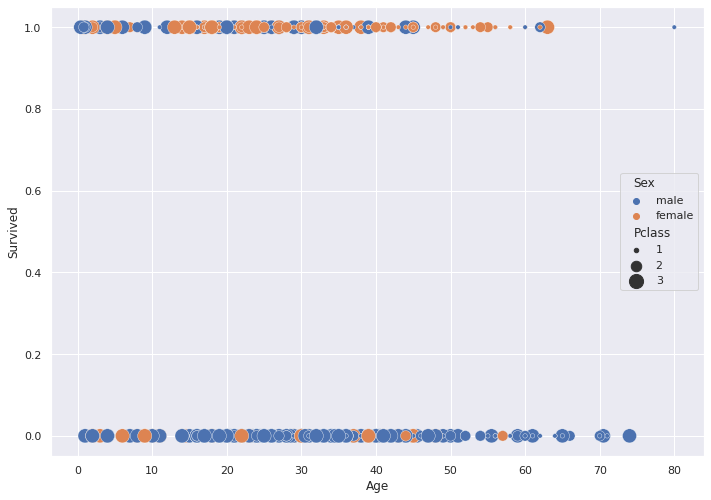

In [6]:
_ = sns.scatterplot(x='Age', y='Survived', hue='Sex', size='Pclass', sizes=(20, 200), data=titanic)

#### Conversion des variables `embarked` et `sex`

In [7]:
titanic = pd.get_dummies(titanic, columns=['Embarked'], prefix = ['emb'], drop_first=True)
titanic['Sex'] = (titanic['Sex'] == 'female').astype(int)
titanic.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'emb_Q', 'emb_S'],
      dtype='object')

In [8]:
X = titanic[['Age', 'Sex','Pclass','SibSp','Parch','Fare','emb_Q','emb_S']]
y = titanic['Survived']

#### Vérification de la proportion des classes positives (Survided) et négatives (Died) 

In [9]:
y.sum()/len(y)

0.3838383838383838

#### Imputation des valeurs manquantes

Les valeurs manquantes seront imputées pour l'exercice pour simplififer

In [10]:
import numpy as np
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean').fit(X)
X = imp.transform(X)

#### Préparation du jeu de test

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X_scale = scaler.transform(X)

In [12]:
from sklearn.model_selection import train_test_split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=2021)

## Exercice 2 - Recherche sur grille

### 2-1 - Régression logistique

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from helpers import plot_roc_curve

[class sklearn.linear_model.LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [ ]:
# Grid
parameters = {'C':[0.01, 0.1, 1, 10, 100],
              'l1_ratio':[0, 0.5, 1]}

# Estimator
clf_logreg = LogisticRegression(penalty='elasticnet',
                                  max_iter=10000,
                                  solver='saga',
                                  random_state=2020)

# GridSearch avec Validation croisée
clf_logreg_grid = GridSearchCV(clf_logreg, parameters, cv=5, scoring="roc_auc", verbose=1, n_jobs=8)

In [ ]:
clf_logreg_grid.fit(X_train, y_train)

In [ ]:
print(f'Meilleurs paramètres: {clf_logreg_grid.best_params_}')
print(f'Meilleur score (mean CV): {clf_logreg_grid.best_score_}')

#### Vérification du meilleur score

In [ ]:
cv_score = cross_val_score(clf_logreg_grid.best_estimator_, X_train, y_train, cv=5, scoring="roc_auc", verbose=1, n_jobs=8)
cv_score.mean()

#### Aire sous la courbe

In [ ]:
y_train_pred_proba_logreg = clf_logreg_grid.best_estimator_.predict_proba(X_train)[:,1]
print(f'AUC = {roc_auc_score(y_train, y_train_pred_proba_logreg)}')

#### Courbe ROC

In [ ]:
results = {}
results['Logistic Regression'] = y_train_pred_proba_logreg
plot_roc_curve(results, y_train)

### 2-2 - K plus proches voisins

In [17]:
from sklearn.neighbors import KNeighborsClassifier

[class sklearn.neighbors.KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None, **kwargs)](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

In [23]:
# Grid
parameters = {
    "n_neighbors": [5, 10, 20, 30, 40, 50],
    "weights": ['uniform','distance'],
}

clf_knn = KNeighborsClassifier(algorithm="brute")

clf_knn_grid = GridSearchCV(clf_knn, parameters, cv=5, scoring="roc_auc", verbose=1, n_jobs=-1)
clf_knn_grid.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(algorithm='brute'), n_jobs=-1,
             param_grid={'n_neighbors': [5, 10, 20, 30, 40, 50],
                         'weights': ['uniform', 'distance']},
             scoring='roc_auc', verbose=1)

In [24]:
print(f'Meilleurs paramètres: {clf_knn_grid.best_params_}')
print(f'Meilleur score (mean CV): {clf_knn_grid.best_score_}')

Meilleurs paramètres: {'n_neighbors': 30, 'weights': 'distance'}
Meilleur score (mean CV): 0.7434361865737845


#### Aire sous la courbe

In [25]:
y_train_pred_proba_knn = clf_knn_grid.best_estimator_.predict_proba(X_train)[:,1]
print(f'AUC = {roc_auc_score(y_train, y_train_pred_proba_knn)}')

AUC = 0.9993462343096234


In [26]:
y_test_pred_proba_knn = clf_knn_grid.best_estimator_.predict_proba(X_test)[:,1]
print(f'AUC = {roc_auc_score(y_test, y_test_pred_proba_knn)}')

AUC = 0.7906443071491616


#### Courbe ROC

In [ ]:
results['KNN'] = y_train_pred_proba_knn
plot_roc_curve(results, y_train)

## Exercice 3 - Recherche aléatoire

### 3-1 - Arbres de décision

In [ ]:
from sklearn.utils.fixes import loguniform
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

[class sklearn.tree.DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, presort='deprecated', ccp_alpha=0.0)](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

In [ ]:
# Distributions des paramètres
distributions = dict(
    criterion=['gini', 'entropy'],
    ccp_alpha=loguniform(1e-3, 1e3),
    max_depth=randint(2, 128))

# Estimateur
clf_tree = DecisionTreeClassifier(random_state=2020)

    
# Recherche aléatoire avec avec validation croisée
clf_tree_rnd = RandomizedSearchCV(clf_tree, distributions, n_iter=1000, cv=5, scoring="roc_auc", verbose=1, n_jobs=8, random_state=2020)

In [ ]:
clf_tree_rnd.fit(X_train, y_train)

In [ ]:
print(f'Meilleurs paramètres: {clf_tree_rnd.best_params_}')
print(f'Meilleur score (mean CV): {clf_tree_rnd.best_score_}')

#### Aire sous la courbe

In [ ]:
y_train_pred_proba_tree = clf_tree_rnd.best_estimator_.predict_proba(X_train)[:,1]
print(f'AUC = {roc_auc_score(y_train, y_train_pred_proba_tree)}')

#### Courbe ROC

In [ ]:
results['Decision Tree'] = y_train_pred_proba_tree
plot_roc_curve(results, y_train)

### 3-2 - Bagging

In [ ]:
from sklearn.ensemble import BaggingClassifier

[class sklearn.ensemble.BaggingClassifier(base_estimator=None, n_estimators=10, max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False, oob_score=False, warm_start=False, n_jobs=None, random_state=None, verbose=0)](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html)

In [ ]:
# Distributions des paramètres
distributions = dict(
    n_estimators=randint(2, 500))

# Estimateur
clf_bag = BaggingClassifier(base_estimator=clf_tree_rnd.best_estimator_, random_state=2021)

# Recherche aléatoire avec validation croisée
clf_bag_rnd = RandomizedSearchCV(clf_bag, distributions, n_iter=100, cv=5, scoring="roc_auc", verbose=1, n_jobs=8, random_state=2020)

In [ ]:
clf_bag_rnd.fit(X_train, y_train)

In [ ]:
print(f'Meilleurs paramètres: {clf_bag_rnd.best_params_}')
print(f'Meilleur score (mean CV): {clf_bag_rnd.best_score_}')

#### Aire sous la courbe

In [ ]:
y_train_pred_proba_bag = clf_bag_rnd.best_estimator_.predict_proba(X_train)[:,1]
print(f'AUC = {roc_auc_score(y_train, y_train_pred_proba_bag)}')

#### Courbe ROC

In [ ]:
results['Bagging (Tree)'] = y_train_pred_proba_bag
plot_roc_curve(results, y_train)

## Exercice 4 - Hyperopt avec Forêts aléatoires et gradient boosting

In [ ]:
!pip install hyperopt

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from hyperopt import hp, fmin, tpe, space_eval

### 4-1 - Gradient boosting

#### Définition de l'hyperespace

In [ ]:
hyperspace = {
    'n_estimators': 1 + hp.randint('n_estimators', 500),
    'lr_rate': hp.loguniform('lr_rate', -8.0, 1.0),
    'max_depth': 1 + hp.randint('max_depth', 100),
    'max_features': hp.choice('max_features', ['sqrt', 'log2', None]),
    'loss': hp.choice('loss', ['deviance', 'exponential']),
    'ccp_alpha': hp.loguniform('ccp_alpha', -6, 2),
}

#### Fonction objective

In [ ]:
def objective(hyperspace):

    lr = hyperspace['lr_rate']
    md = hyperspace['max_depth']
    n = hyperspace['n_estimators']
    l = hyperspace['loss']
    mf = hyperspace['max_features']
    a = hyperspace['ccp_alpha']

    clf_gb = GradientBoostingClassifier(loss=l, max_features=mf,
                                                n_estimators=n, learning_rate=lr, max_depth=md,
                                                ccp_alpha=a,
                                                random_state=2020)
    clf_gb.fit(X_train, y_train)
    cv_score = cross_val_score(clf_gb, X_train, y_train, cv=5, scoring="roc_auc", verbose=0, n_jobs=8)

    return -cv_score.mean()

#### Lancement de l'optimisation

In [ ]:
best = fmin(objective, hyperspace, algo=tpe.suggest, max_evals=100)

#### Meilleurs paramètres

In [ ]:
best

#### Réentraînement du gradient boosting avec les meilleurs hyperparamètres

In [ ]:
clf_hp_gb = GradientBoostingClassifier(loss='exponential', max_features='log2',
                                                n_estimators=350, learning_rate=0.04699952299114128, max_depth=22,
                                                ccp_alpha=0.003263593371701917,
                                                random_state=2020)
clf_hp_gb.fit(X_train, y_train)
cv_score = cross_val_score(clf_hp_gb, X_train, y_train, cv=5, scoring="roc_auc", verbose=0, n_jobs=8)
cv_score.mean()

#### Aire sous la courbe

In [ ]:
y_train_pred_proba_gb = clf_hp_gb.predict_proba(X_train)[:,1]
print(f'AUC = {roc_auc_score(y_train, y_train_pred_proba_gb)}')

#### Courbe ROC

In [ ]:
results['Gradient Boosting'] = y_train_pred_proba_gb
plot_roc_curve(results, y_train)

### 4-2 - Gradient boosting et forêts aléatoires (optionnel)

In [ ]:
# Définition de l'hyperespace

hyperspace = hp.choice('classifier',[
    {
        'type': 'gradient-boosting',
        'n_estimators': 1 + hp.randint('n_estimators_1', 100),
        'lr_rate': hp.loguniform('lr_rate', -8, 1),
        'max_depth': 1 + hp.randint('max_depth', 100),
        'max_features': hp.choice('max_features1', ['sqrt', 'log2', None]),
        'loss': hp.choice('loss', ['deviance', 'exponential']),
        'ccp_alpha': hp.loguniform('ccp_alpha1', -6, 2)
    },
    {
        'type': 'random-forests',
        'criterion': hp.choice('criterion', ['gini', 'entropy']),
        'n_estimators': 1 + hp.randint('n_estimators_2', 500),
        'max_features': hp.choice('max_features2', ['sqrt', 'log2', None]),
        'ccp_alpha': hp.loguniform('ccp_alpha2', -6, 2)
    }
])

# Fonction objective

def objective(hyperspace):

    if hyperspace['type'] == 'gradient-boosting':
        lr = hyperspace['lr_rate']
        md = hyperspace['max_depth']
        n = hyperspace['n_estimators']
        l = hyperspace['loss']
        mf = hyperspace['max_features']
        a = hyperspace['ccp_alpha']

        clf_gb = GradientBoostingClassifier(loss=l, max_features=mf,
                                            n_estimators=n, learning_rate=lr, max_depth=md,
                                            ccp_alpha=a,
                                            random_state=2020)
        clf_gb.fit(X_train, y_train)
        cv_score = cross_val_score(clf_gb, X_train, y_train, cv=5, scoring="roc_auc", verbose=0, n_jobs=8)

        return -cv_score.mean()
    elif hyperspace['type'] == 'random-forests':
        c = hyperspace['criterion']
        n = hyperspace['n_estimators']
        mf = hyperspace['max_features']
        a = hyperspace['ccp_alpha']
        
        clf_rf = RandomForestClassifier(criterion=c, n_estimators=n, max_features=mf, ccp_alpha=a,
                                        random_state=2020,
                                        n_jobs=8)
        clf_rf.fit(X_train, y_train)
        cv_score = cross_val_score(clf_rf, X_train, y_train, cv=5, scoring="roc_auc", verbose=0, n_jobs=8)

        return -cv_score.mean()
    else:
        print("Error")
        return None

# Lancement de l'optimisation

best = fmin(objective, hyperspace, algo=tpe.suggest, max_evals=100)
best

## Exercice 5 - Performances sur le jeu de tests

#### Aire sous la courbe

In [ ]:
y_test_pred_proba_gb = clf_hp_gb.predict_proba(X_test)[:,1]
print(f'AUC = {roc_auc_score(y_test, y_test_pred_proba_gb)}')

#### Courbe ROC

In [ ]:
results_test = {}
results_test['Gradient Boosting'] = y_test_pred_proba_gb
plot_roc_curve(results_test, y_test)